# Hands-on assignments online course in topology
##### Author: Jannes van Poppelen <<jannes.vanpoppelen@physics.uu.se>>, September/October 2024

## Importing libraries and initialization of some functions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import kwant
import scipy
import collections
import itertools
from copy import copy
from scipy.linalg import eigh
from scipy.interpolate import griddata
from pfapack import pfaffian as pf
import ipywidgets as widgets
from types import SimpleNamespace
from numpy import sqrt as sqrt


In [2]:
np.random.seed(123456789)
matplotlib.rcParams["figure.dpi"] = 70
np.set_printoptions(formatter={'all': lambda x: "{:.2g}".format(x)})

pauli = SimpleNamespace(
    s0=np.array([[1.0, 0.0], [0.0, 1.0]]),
    sx=np.array([[0.0, 1.0], [1.0, 0.0]]),
    sy=np.array([[0.0, -1j], [1j, 0.0]]),
    sz=np.array([[1.0, 0.0], [0.0, -1.0]]),
)

pauli.s0s0 = np.kron(pauli.s0, pauli.s0)
pauli.s0sx = np.kron(pauli.s0, pauli.sx)
pauli.s0sy = np.kron(pauli.s0, pauli.sy)
pauli.s0sz = np.kron(pauli.s0, pauli.sz)
pauli.sxs0 = np.kron(pauli.sx, pauli.s0)
pauli.sxsx = np.kron(pauli.sx, pauli.sx)
pauli.sxsy = np.kron(pauli.sx, pauli.sy)
pauli.sxsz = np.kron(pauli.sx, pauli.sz)
pauli.sys0 = np.kron(pauli.sy, pauli.s0)
pauli.sysx = np.kron(pauli.sy, pauli.sx)
pauli.sysy = np.kron(pauli.sy, pauli.sy)
pauli.sysz = np.kron(pauli.sy, pauli.sz)
pauli.szs0 = np.kron(pauli.sz, pauli.s0)
pauli.szsx = np.kron(pauli.sz, pauli.sx)
pauli.szsy = np.kron(pauli.sz, pauli.sy)
pauli.szsz = np.kron(pauli.sz, pauli.sz)

In [3]:
randn = np.random.randn # random integer generator
def make_random_real_ham(N):
    H = randn(N, N)
    H += H.T
    return H / 2

def make_cons_ham(N): # Hamiltonian with conservation law i.e. sigma_z^dagger H sigma_z = H
    H = np.kron(pauli.s0, randn(N, N)) + np.kron(pauli.sz, randn(N, N))
    H += H.T.conj()
    return H / 2

def make_random_ham(N):
    H = randn(N, N) + 1j * randn(N, N)
    H += H.T.conj()
    return H / 2

def make_random_symplectic_ham(N):
    if N % 2:
        raise ValueError("Matrix dimension should be a multiple of 2")
    sy = np.kron(np.eye(N // 2), np.array([[0, -1j], [1j, 0]]))
    h = randn(N, N) + 1j * randn(N, N)
    h += h.T.conj()
    Th = sy @ h.conj() @ sy
    return (h + Th) / 4

def make_chiral_ham(N):
    temp1 = randn(N, N) + 1j * randn(N, N)
    temp2 = randn(N, N) + 1j * randn(N, N)
    H = np.kron(pauli.sx, temp1) + np.kron(pauli.sy, temp2)
    H += H.T.conj()
    return H / 2

def make_BdG_ham(N):
    # This is antisymmetric basis
    H = 1j * randn(2 * N, 2 * N)
    H += H.T.conj()
    return H / 2


def energies(alpha, H0, H1):
    H = (1 - alpha) * H0 + alpha * H1
    return np.linalg.eigvalsh(H)


def find_spectrum(alphas, H0, H1):
    spectrum = [energies(a, H0, H1) for a in alphas]
    return np.array(spectrum)

In [4]:
def find_pfaffian(alphas, H0, H1):
    """Function caculates the Pfaffian for a Hamiltonian.

    Parameters:
    -----------
    alphas : numpy array
        Range of alphas for which the energies are calculated.
    H0 : numpy array
        Hamiltonian, same size as H1.
    H1 : numpy array
        Hamiltonian, same size as H0.

    Returns:
    --------
    pfaffians : numpy array
        Pfaffians for each alpha.
    """

    def H(alpha):
        return (1 - alpha) * H0 + alpha * H1

    pfaffians = [np.sign(np.real(pf.pfaffian(1j * H(a), method = "P"))) for a in alphas]
    return np.array(pfaffians)

In [5]:
def berry_curvature(syst, p, ks, num_filled_bands=1):
    """Berry curvature of a system.

    Parameters:
    -----------
    sys : kwant.Builder
        A 2D infinite system.
    p : dict
        The arguments expected by the system.
    ks : 1D array-like
        Values of momentum grid to be used for Berry curvature calculation.
    num_filled_bands : int
        The number of filled bands.

    Returns:
    --------
    bc : 2D array
        Berry curvature on each square in a `ks x ks` grid.
    """
    # Calculate an array of eigenvectors.
    B = np.array(syst.symmetry.periods).T
    A = B @ np.linalg.inv(B.T @ B)

    syst = kwant.wraparound.wraparound(syst).finalized()

    def filled_states(kx, ky):
        k = np.array([kx, ky])
        kx, ky = np.linalg.solve(A, k)
        p.update(k_x=kx, k_y=ky)
        H = syst.hamiltonian_submatrix(params=p, sparse=False)
        return scipy.linalg.eigh(H)[1][:, :num_filled_bands]

    vectors = np.array(
        [[filled_states(kx, ky) for kx in ks] for ky in ks]
    )

    # The actual Berry curvature calculation
    vectors_x = np.roll(vectors, 1, 0)
    vectors_xy = np.roll(vectors_x, 1, 1)
    vectors_y = np.roll(vectors, 1, 1)

    shifted_vecs = [vectors, vectors_x, vectors_xy, vectors_y]

    v_shape = vectors.shape

    shifted_vecs = [i.reshape(-1, v_shape[-2], v_shape[-1]) for i in shifted_vecs]

    dets = np.ones(len(shifted_vecs[0]), dtype=complex)
    for vec, shifted in zip(shifted_vecs, np.roll(shifted_vecs, 1, 0)):
        dets *= [np.linalg.det(a.T.conj() @ b) for a, b in zip(vec, shifted)]
    bc = np.angle(dets).reshape(int(np.sqrt(len(dets))), -1)

    bc = (bc + np.pi / 2) % (np.pi) - np.pi / 2

    return bc

In [6]:
def hamiltonian_array(syst, params=None, k_x=0, k_y=0, k_z=0, return_grid=False):
    """Evaluate the Hamiltonian of a system over a grid of parameters.

    Parameters:
    -----------
    syst : kwant.Builder object
        The un-finalized kwant system whose Hamiltonian is calculated.
    params : dictionary
        A container of Hamiltonian parameters. The parameters that are
        sequences are used to loop over.
    k_x, k_y, k_z : floats or sequences of floats
        Momenta at which the Hamiltonian has to be evaluated.  If the system
        only has 1 translation symmetry, only `k_x` is used, and interpreted as
        lattice momentum. Otherwise the momenta are in reciprocal space.
    return_grid : bool
        Whether to also return the names of the variables used for expansion,
        and their values.

    Returns:
    --------
    hamiltonians : numpy.ndarray
        An array with the Hamiltonians. The first n-2 dimensions correspond to
        the expanded variables.
    parameters : list of tuples
        Names and ranges of values that were used in evaluation of the
        Hamiltonians.

    Examples:
    ---------
    >>> hamiltonian_array(syst, dict(t=1, mu=np.linspace(-2, 2)),
    ...                   k_x=np.linspace(-np.pi, np.pi))
    >>> hamiltonian_array(sys_2d, p, np.linspace(-np.pi, np.pi),
    ...                   np.linspace(-np.pi, np.pi))

    """
    # Prevent accidental mutation of input
    params = copy(params)
    try:
        space_dimensionality = syst.symmetry.periods.shape[-1]
    except AttributeError:
        space_dimensionality = 0
    dimensionality = syst.symmetry.num_directions

    if dimensionality == 0:
        syst = syst.finalized()

        def momentum_to_lattice(k):
            return {}

    else:
        if len(syst.symmetry.periods) == 1:

            def momentum_to_lattice(k):
                if any(k[dimensionality:]):
                    raise ValueError("Dispersion is 1D, but more momenta are provided.")
                return {"k_x": k[0]}

        else:
            B = np.array(syst.symmetry.periods).T
            A = B @ np.linalg.inv(B.T @ B)

            def momentum_to_lattice(k):
                lstsq = np.linalg.lstsq(A, k[:space_dimensionality], rcond=-1)
                k, residuals = lstsq[:2]
                if np.any(abs(residuals) > 1e-7):
                    raise RuntimeError(
                        "Requested momentum doesn't correspond"
                        " to any lattice momentum."
                    )
                return dict(zip(["k_x", "k_y", "k_z"], list(k)))

        syst = kwant.wraparound.wraparound(syst).finalized()

    changing = dict()
    for key, value in params.items():
        if isinstance(value, collections.abc.Iterable):
            changing[key] = value

    for key, value in [("k_x", k_x), ("k_y", k_y), ("k_z", k_z)]:
        if key in changing:
            raise RuntimeError(
                "One of the system parameters is {}, "
                "which is reserved for momentum. "
                "Please rename it.".format(key)
            )
        if isinstance(value, collections.abc.Iterable):
            changing[key] = value


    def hamiltonian(**values):
        k = [values.pop("k_x", k_x), values.pop("k_y", k_y), values.pop("k_z", k_z)]
        params.update(values)
        k = momentum_to_lattice(k)
        system_params = {**params, **k}
        return syst.hamiltonian_submatrix(params=system_params, sparse=False)

    names, values = zip(*sorted(changing.items()))


    hamiltonians = [
        hamiltonian(**dict(zip(names, value))) for value in itertools.product(*values)
    ] if changing else [
        hamiltonian(k_x=k_x, k_y=k_y, k_z=k_z)
    ]
    size = list(hamiltonians[0].shape)

    hamiltonians = np.array(hamiltonians).reshape(
        [len(value) for value in values] + size
    )

    if return_grid:
        return hamiltonians, list(zip(names, values))
    else:
        return hamiltonians

## Week 1: Topology in toy models ✅

#### PHS and TRS Hamiltonian

In [11]:
# Function to check if matrix H satisfies both PHS and TRS
def check_symmetry(H):
    N = H.shape[0]//2
    taux = np.kron(pauli.sx, np.eye(N))
    sy = np.kron(np.eye(N), pauli.sy)
    PHS_satisfied = np.allclose(taux @ H.conj() @ taux, -H)
    TRS_satisfied = np.allclose(sy @ H.conj() @ sy, H)
    # print(taux @ H.conj() @ taux)
    # print(-H)
    return PHS_satisfied, TRS_satisfied



def PH_TR_Ham(N):
    htrs = make_random_symplectic_ham(N)
    h = np.block([
    [htrs, np.zeros(htrs.shape)],
    [np.zeros(htrs.shape), -htrs.conj()]])
    return h - h.conj()
h = PH_TR_Ham(4)

# print(check_symmetry(h))
# np.linalg.norm(h + h.T)

dim(h) = 4


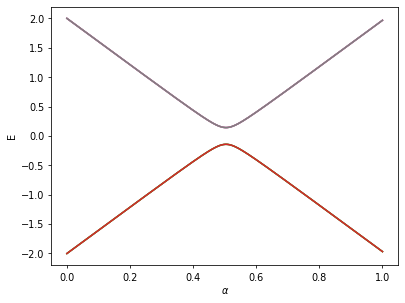

In [12]:
H0 = PH_TR_Ham(4)
H1 = PH_TR_Ham(4)
alphas = np.linspace(0, 1, 1000)
spec = find_spectrum(alphas, H0, H1)
print(f"dim(h) = {H0.shape[0]//2}")
plt.plot(alphas, spec);
plt.xlabel(r"$\alpha$")
plt.ylabel("E")
plt.show()

A Hamiltonian that has both particle-hole symmetry and time-reversal symmetry "suffers" from Kramers Degeneracy. Hence it is symmetric around E = 0 (PHS), and every state is double degenerate (TRS). In particular also the zero-energy states. 

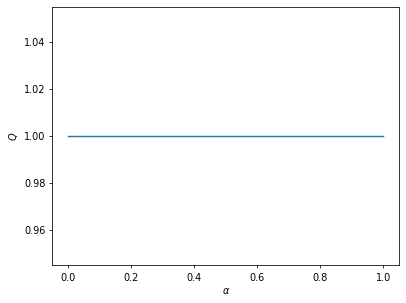

In [13]:
pfaffian = find_pfaffian(alphas, H0, H1)
plt.plot(alphas, pfaffian)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$Q$')
plt.show()

Since we have double degenerate states, Q never changes sign as there is always an even number of crossings. Somehow TRS + PRS prevents any crossings (while it should not), according to the form of the matrix. I believe it might be incorrectly generated. Pfaffian changes sign only when you have an odd number of crossings. Since we have TRS, we will always have even number of zero energy crossings. 

#### SSH Chain

In [14]:
def ssh_chain(L, t2, mu):
    a = 1.0 
    lat = kwant.lattice.general([(a,)], [(0, ), (0.5,)], norbs=1)
    A, B = lat.sublattices  # Unpack the sublattices
    sys = kwant.Builder()

    # Define hopping terms
    t1 = 1  # Intra-cell hopping

    # Add sites and hoppings to the system
    for i in range(L):
        # Add site A and B for each unit cell
        sys[A(i)] = mu  # Site A
        sys[B(i)] = -mu  # Site B
    
        # Add intra-cell hopping (A-B within the same unit cell)
        sys[A(i), B(i)] = t1
    
    # Add inter-cell hopping (B to A between adjacent unit cells)
    for i in range(L - 1):
        sys[B(i), A(i + 1)] = t2  # Hopping from B to A of the next cell

    return sys
    
# kwant.plot(sys);

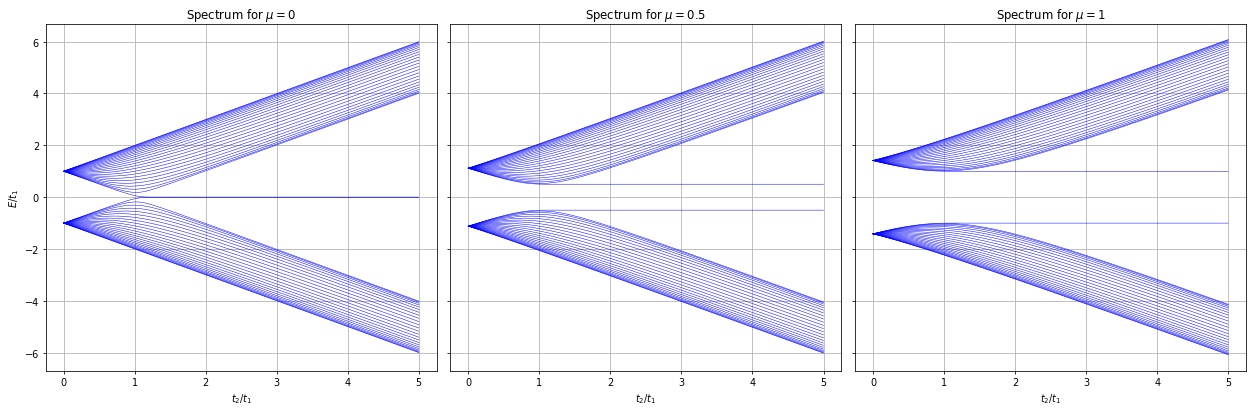

In [15]:
L = 25
mus = [0, 0.5, 1]
t2_values = np.linspace(0, 5, 100) 
energies = {mu: [] for mu in mus} 

for mu in mus:
    for t2 in t2_values:
        sys = ssh_chain(L, t2, mu)
        finalized_sys = sys.finalized()
        hamiltonian = finalized_sys.hamiltonian_submatrix()
        eigenvalues = np.linalg.eigvalsh(hamiltonian)
        energies[mu].append(eigenvalues)


energies = {mu: np.array(energies[mu]) for mu in mus}

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True, dpi=70)
for idx, mu in enumerate(mus):
    for i in range(energies[mu].shape[1]):
        axs[idx].plot(t2_values, energies[mu][:, i], color='blue', linewidth=0.5)
    axs[idx].set_xlabel(r'$t_2/t_1$')
    axs[idx].set_title(fr'Spectrum for $\mu = {mu}$')
    axs[idx].grid(True)

axs[0].set_ylabel(r'$E/t_1$')

plt.tight_layout()
plt.show()

Edge states of SSH model are protected by chiral symmetry. We can break this symmetry by applying a different chemical potential on each sublattice.

## Week 2: Majoranas ✅

#### Tilted magnetic field

In [16]:
def nanowire_chain(Bx, By, Bz, params):
    t = params['t']
    mu = params['mu']
    delta = params['delta']
    alpha = params['alpha']
    lat = kwant.lattice.chain(norbs=4)
    nanowire_chain = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))

    onsite_term = (2 * t - mu) * pauli.szs0 + Bx * pauli.s0sx + By * pauli.s0sy + Bz * pauli.s0sz + delta * pauli.sxs0
    nanowire_chain[lat(0)] = onsite_term

    nanowire_chain[kwant.HoppingKind((1,), lat)] = (
        -t * pauli.szs0 - 0.5j * alpha * pauli.szsx
    )

    return nanowire_chain

params = dict(t=1.0, mu=0.1, delta=0.1, alpha=0.15)
sys = nanowire_chain(0, 0, 1, params)
# kwant.plot(sys);


In [17]:
def plot_bands(Bx, By, Bz):
    # Create the system with the given magnetic fields
    sys = nanowire_chain(Bx, By, Bz, params)
    fsys = sys.finalized()

    # Plotting the band structure with a uniform color
    plt.figure(figsize=(8, 6), dpi = 120)
    kwant.plotter.bands(fsys, show=False, momenta = 1000);  # Change 'blue' to your desired color
    plt.title(fr'Band Structure for $B_x$={np.round(Bx,3)}, $B_y$={np.round(By,3)}, $B_z$={np.round(Bz,3)}')
    plt.xlabel(r'$k$')
    plt.ylabel(r'$E$')
    plt.ylim((-1,1))
    plt.xlim((-1,1))
    plt.grid(True)
    plt.show()

Bx_slider = widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description='Bx:')
By_slider = widgets.FloatSlider(value=0, min=-0.5, max=0.5, step=0.01, description='By:')
Bz_slider = widgets.FloatSlider(value=0.2, min=-0.5, max=0.5, step=0.01, description='Bz:')


interactive_plot = widgets.interactive(plot_bands, Bx=Bx_slider, By=By_slider, Bz=Bz_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, description='Bx:', max=0.5, min=-0.5, step=0.01), FloatSlider(val…

Changing $B_x$ allows us to "tilt" the bandstructure. Changing $B_y$ behaves similarly to $B_z$.

## Week 3: More parameters: Charge Pumping ✅

#### Butterfly

/home/jannes/miniconda3/envs/venv/lib/python3.12/site-packages/kwant/lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)


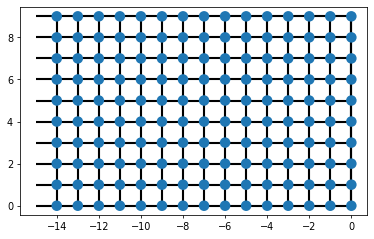

In [18]:
def onsite(site, t, mu):
    return 4 * t - mu

def hopping(site1, site2, t, B):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    hop = -t * np.exp(-0.5j * B * (x1 - x2) * (y1 + y2))  # Peierls substitution    
    return hop

def qhe_cylinder(W=10):
    lat = kwant.lattice.square()
    syst = kwant.Builder(kwant.TranslationalSymmetry((-15, 0))) # Periodic BC is a problem for some reason. Take more than one unit cell.

    syst[lat.shape((lambda pos: 0 <= pos[1] < W), (0, 0))] = onsite
    syst[lat.neighbors()] = syst[lat(0, 0), lat(0, W-1)] = hopping
    
    return syst

sys = qhe_cylinder()
kwant.plot(sys);

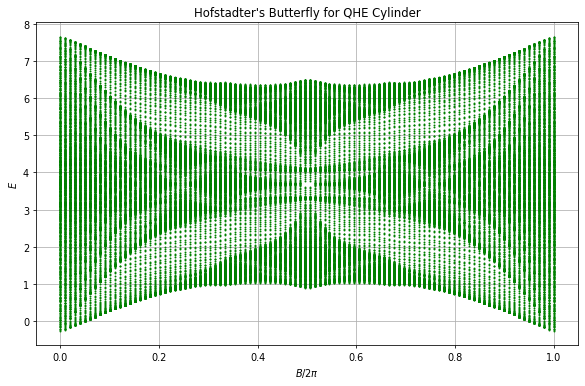

In [19]:
t = 1.
mu = 0.3
B_vals = np.linspace(0, 2 * np.pi, 100)
energies = []
sys = qhe_cylinder(50)
fsys = sys.finalized()

for B in B_vals:
    ham = fsys.hamiltonian_submatrix(params=dict(t=t, mu=mu, B=B))
    eigenvalues = np.linalg.eigvalsh(ham)
    energies.append(eigenvalues)

energies = np.array(energies)

plt.figure(figsize=(10, 6))
for i in range(energies.shape[1]):
    plt.plot(B_vals/(2*np.pi), energies[:, i], 'g.', markersize=2)

plt.xlabel(r'$B/2\pi$')
plt.ylabel(r'$E$')
plt.title("Hofstadter's Butterfly for QHE Cylinder")
plt.grid(True)
plt.show()

#### Graphene Hall bar

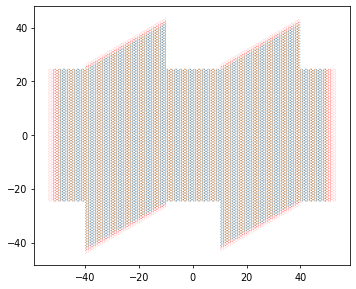

In [20]:
def graphene_hall_bar(L=50, W=10, w_lead=8):

    lat = kwant.lattice.general([(sqrt(3)*1/2, 1/2), (0,1)], [(0,0), (1/(2*sqrt(3)), 1/2)], norbs = 1)
    a, b = lat.sublattices

    L = 2 * (L // 2)
    W = 2 * (W // 2)
    w_lead = 2 * (w_lead // 2)
    w_vert_lead = w_lead

    # bar shape
    def bar(pos):
        (x, y) = pos
        return abs(x) < L / 2 and abs(y) < W / 2

    # Onsite and hoppings
    def onsite(site, t, mu):
        return 4*t- mu

    def lead_onsite(site, t, mu_lead):
        return 4*t- mu_lead
    
    def make_lead_hop_y(x0):
        def hopping_Ay(site1, site2, t, B):
            y1 = site1.pos[1]
            y2 = site2.pos[1]
            return -t * np.exp(-1j * B * x0* (y1 - y2))
    
        return hopping_Ay


    def hopping_Ax(site1, site2, t, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        hop = -t * np.exp(-1j * B * (x1 + x2) * (y1 - y2)/2)
        return hop

    sys = kwant.Builder()
    sys[lat.shape(bar, (0, 0))] = onsite
    sys[lat.neighbors()] = hopping_Ax

    # LEADS
    #L-R leads
    def lead_shape(pos):
        x, y = pos
        return abs(y) < W/2

    sym = kwant.TranslationalSymmetry(lat.vec((2, -1)))
    # print(lat.vec((-2, 1)))
    # print(lat.vec((0, -1)))
    L0 = kwant.Builder(sym)
    L0[lat.shape(lead_shape, (0,0))] = lead_onsite
    L0[lat.neighbors()] = make_lead_hop_y(L/2)
    
    L1 = kwant.Builder(sym)
    L1[lat.shape(lead_shape, (0,0))] = lead_onsite
    L1[lat.neighbors()] = make_lead_hop_y(-L/2)

    #Top-bottom leads
    sym_lead_vertical = kwant.TranslationalSymmetry(lat.vec((0, 1)))
    lead_vertical1 = kwant.Builder(sym_lead_vertical)
    lead_vertical2 = kwant.Builder(sym_lead_vertical)

    def lead_shape_vertical1(pos):
        x, y = pos
        return -L / 4 - w_vert_lead / 2 < pos[0] < -L / 4 + w_vert_lead / 2

    def lead_shape_vertical2(pos):
        x, y = pos
        return +L / 4 - w_vert_lead / 2 <= pos[0] <= +L / 4 + w_vert_lead / 2

    lead_vertical1[lat.shape(lead_shape_vertical1, (-L / 4, 0))] = lead_onsite
    lead_vertical1[lat.neighbors()] = make_lead_hop_y(0)
    lead_vertical2[lat.shape(lead_shape_vertical2, (L / 4, 0))] = lead_onsite
    lead_vertical2[lat.neighbors()] = make_lead_hop_y(0)

    # Make sure leads are attached in correct order 
    sys.attach_lead(lead_vertical1)
    sys.attach_lead(lead_vertical2)
    sys.attach_lead(lead_vertical1.reversed())
    sys.attach_lead(lead_vertical2.reversed())
    sys.attach_lead(L1.reversed())
    sys.attach_lead(L0)

    
    return sys


sys = graphene_hall_bar()
# kwant.plot(sys);
p = dict(t=1., mu=0.3, mu_lead=0.3, B = 0.5)
sys = graphene_hall_bar(L= 100, W = 50, w_lead =30)
kwant.plot(sys)
fsys = sys.finalized()
# h = fsys.hamiltonian_submatrix(params = p)
# E = np.linalg.eigvalsh(h)
# plt.xlabel("State number")
# plt.ylabel("E")
# plt.plot(E)
# print(kwant.smatrix(fsys,params=p, energy= 5).conductance_matrix())

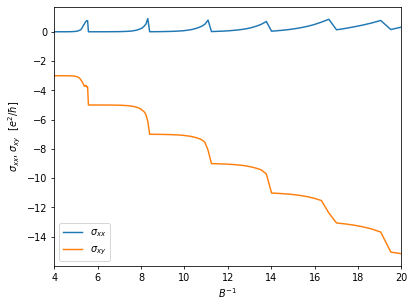

In [27]:
p = dict(t=1.0, mu=0.3, mu_lead=0.3, B = 0.1)
sys = graphene_hall_bar(L= 100, W = 60, w_lead = 30)
fsys = sys.finalized()
def conductivities(syst, p):
    G = kwant.smatrix(syst,params=p, energy = 3).conductance_matrix() # choose a correct energy, else s-matrix is singular 
    
    # Voltages are given by G V = I
    V = np.linalg.solve(G[:-1, :-1], [0, 0, 0, 0, 1])
    # Consider the 2x2 conductance now: Use I = sigma U
    E_x = V[0] - V[1]
    E_y = V[1] - V[3]
    sigma_xx = E_x / (E_x ** 2 + E_y ** 2)
    sigma_xy = E_y / (E_x ** 2 + E_y ** 2)
    return sigma_xx, sigma_xy


Blist = np.linspace(0.05, 0.30, 200)
Binv = [1/B for B in Blist]
sigmasxx, sigmasxy = zip(*[conductivities(fsys, p) for p["B"] in Blist])

plt.xlabel(r"$B^{-1}$")
plt.ylabel(r"$\sigma_{xx}$, $\sigma_{xy}$  $[e^2/\hbar]$")
plt.plot(Binv, sigmasxx, label = r"$\sigma_{xx}$")
plt.plot(Binv, sigmasxy, label = r"$\sigma_{xy}$")
plt.xlim((4, 20))
plt.legend(loc='lower left')

One can more or less observe the unconventional quantum Hall effect, with the transverse conductivity appearing like in https://arxiv.org/abs/cond-mat/0602565. I'm sure the results will get more accurate with increasing system and lead sizes. I however do not understand the physics of why the conductivity flips sign compared to the conventional quantum Hall effect.

## Week 4: Chern Insulators ✅

#### Yet another Chern insulator

This model is based off of PhysRevB.102.035145. $t$ is the normal (kinetic) hopping, $M$ is a staggerd mass term, and $l$ is the cross-coupling, which is an effective spin-orbit coupling.

/home/jannes/miniconda3/envs/venv/lib/python3.12/site-packages/kwant/_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


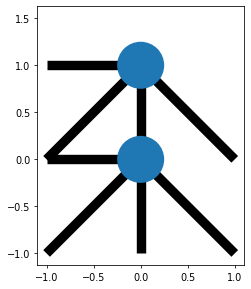

interactive(children=(FloatSlider(value=1.0, description='$t$:', max=1.0), FloatSlider(value=0.5, description=…

In [7]:
def hopx(site1, site2, t, l):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return (-1)**y2*t/2*1j
    
def hopy(site1, site2, t, l):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return t/2

def hopNNN(site1, site2, l):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    if (x1 + y1) % 2 == 0:
        return l / 2
    else:
        return 0 
    

def onsite(site, M):
    x, y = site.pos
    return (-1)**(y)*M

def chern_insulator():
    
    lat = kwant.lattice.square(1, norbs=1)
    vecs=lat.prim_vecs*[1, 2]
    
    syst = kwant.Builder(kwant.TranslationalSymmetry(*(vecs)))

    syst[lat(0,0)] = onsite
    syst[lat(0,1)] = onsite
    
    # hoppings in x-direction
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hopx
    # hoppings in y-directions
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hopy
    # NNN hoppings
    syst[kwant.builder.HoppingKind((1, 1), lat, lat)] = hopNNN
    syst[kwant.builder.HoppingKind((-1, 1), lat, lat)] = hopNNN
    return syst

kwant.plot(chern_insulator());

def plot_bands(t, l, M):
    k = np.linspace(-np.pi, np.pi, 100)
    wrapped = kwant.wraparound.wraparound(chern_insulator()).finalized()
    kwant.wraparound.plot_2d_bands(wrapped, k_x=k, k_y=k, params = dict(t=t, l=l, M=M));
    return 
    
t_slider = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description=r'$t$:')
l_slider = widgets.FloatSlider(value=0.5, min=-2, max=2, step=0.05, description=r'$l$:')
M_slider = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.1, description=r'$M$:')
interactive_plot = widgets.interactive(plot_bands, t=t_slider, l=l_slider, M=M_slider)
display(interactive_plot)

In [8]:
def plot_berry_curvature(t, l, M):
    # Set the parameter dictionary
    p = dict(t=t, l=l, M=M)
    
    # Create the Chern insulator model with the given M
    CI = chern_insulator()
    
    # Define the k-space grid
    ks = np.linspace(-2 * np.pi, 2 * np.pi, 200, endpoint=False)
    
    # Compute the Berry curvature
    bc = berry_curvature(CI, p, ks)
    
    # Plot the Berry curvature
    plt.figure(figsize=(4, 4), dpi=100)
    plt.imshow(bc, extent=(-2 * np.pi, 2 * np.pi, -2 * np.pi, 2 * np.pi), origin='lower', cmap='seismic')
    plt.colorbar(label=r'Berry Curvature')
    plt.title(f'Berry Curvature for t={np.round(t,3)}, l={np.round(l,3)}, M={np.round(M,3)}')
    plt.xlabel(r'$k_x$')
    plt.ylabel(r'$k_y$')
    plt.show()

t_slider = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description=r'$t$:')
l_slider = widgets.FloatSlider(value=0.5, min=-2, max=2, step=0.05, description=r'$l$:')
M_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description=r'$M$:')

# Create the interactive plot
interactive_plot = widgets.interactive(plot_berry_curvature, t=t_slider, l=l_slider, M=M_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='$t$:', max=1.0), FloatSlider(value=0.5, description=…

In the system, $l$ modulates the NNN coupling (and hence also the SOC). As $l=0$, the system is in the trivial phase with trivial Berry Curvature. As $l$ shifts away from zero, it induces a non-trivial Berry curvature in the system, whose sign also depends on the sign of $l$. $M$ is a staggered mass term that acts differently on the two sublattices. The Berry curvature should be trivial for $(l/t=2, M=0.5)$, but it seems like this is not entirely the case. Still, the system exhibits properties of a Chern insulator.

In [9]:
def plot_CI_edge(t, l, M):
    L = 20
    p = dict(t=t, l=l, M=M)
    CI_infinite = chern_insulator()
    lat = kwant.lattice.square(1, norbs=1)
    vecs=lat.prim_vecs*[1, 2]
    # ribbon with translational symmetry in y direction makes no sense as that 
    # gives uncoupled wires; dispersion takes the cos^2 form
    x_ribbon = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
    x_ribbon[lat.shape((lambda pos: 0<= pos[1] < L), (0, 0))] = onsite
    x_ribbon[kwant.builder.HoppingKind((1, 0), lat, lat)] = hopx
    x_ribbon[kwant.builder.HoppingKind((0, 1), lat, lat)] = hopy
    # hopping diagonally
    x_ribbon[kwant.builder.HoppingKind((1, 1), lat, lat)] = hopNNN
    
    # Plot the band structure
    plt.figure(figsize=(8, 6), dpi=120)
    k = np.linspace(-np.pi, np.pi, 500)
    kwant.plotter.bands(x_ribbon.finalized(), momenta = k, params=p, show=False)
    plt.title('Edge states of CI on square lattice')
    plt.xlabel(r'$k$')
    plt.ylabel(r'$E$')
    plt.ylim((-2, 2))

    plt.grid(True)
    plt.show()



t_slider = widgets.FloatSlider(value=1, min=0.0, max=1.0, step=0.1, description=r'$t$:')
l_slider = widgets.FloatSlider(value=0.5, min=-1.0, max=1.0, step=0.05, description=r'$l$:')
M_slider = widgets.FloatSlider(value=0., min=0.0, max=1.0, step=0.1, description=r'$M$:')
interactive_plot = widgets.interactive(plot_CI_edge, t=t_slider, l=l_slider, M=M_slider)
display(interactive_plot)


# kwant.plotter.bands(x_ribbon.finalized(), params = p);

interactive(children=(FloatSlider(value=1.0, description='$t$:', max=1.0), FloatSlider(value=0.5, description=…

$M$ breaks chiral symmetry, however, this need not give rise to edge states. There is a regime in which the Berry curvature is non-trivial, but there do not exist any edge states $(t=1, |l|=0.1)$. The edge states seem quite robust against the breaking of chiral symmetry.

## Week 5: Quantum Spin Hall Effect ✅

#### Kane-Mele model

The scattering matrix topological invariant of a topological insulator is determined purely by the reflection matrix. It is given by $$Q = \frac{\mathrm{Pf}[r(0)]}{\mathrm{Pf}[r(\pi)]} \sqrt{\frac{\mathrm{det}[r(\pi)]}{\mathrm{det}[r(0)]}}$$
To be able to get the topological invariant using kwant, we need to attach leads to either side of the system, and roll up the system so we get a one-dimensional problem of which we can access scattering matrix at $k=0$ and $k=\pi$.

Model is taken/inspired by https://github.com/kwant-project/kwant-tutorial-2016.

In [10]:
def bulk_km():
    lat = kwant.lattice.general([(sqrt(3)*1/2, 1/2), (0,1)], [(0,0), (1/(2*sqrt(3)), 1/2)], norbs = 2)
    a, b = lat.sublattices

    nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
    nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
    nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b

    def NN(site1, site, t1):
        return t1*pauli.s0

    def SOC(site1, site2, t2):
        return 1j * t2 * pauli.sz # Conjugate SOC for spin up/spin down
    
    def onsite(site, M):
        return pauli.s0 * M * (1 if site.family == a else -1)

    sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
    sys[lat.shape(lambda pos: True, (0,0))] = onsite
    sys[lat.neighbors()] = NN 
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = SOC

    return sys

# kwant.plot(bulk_km());


def plot_bands(t1, t2, M):
    k = np.linspace(-np.pi, np.pi, 100)
    wrapped = kwant.wraparound.wraparound(bulk_km()).finalized()
    kwant.wraparound.plot_2d_bands(wrapped, k_x=k, k_y=k, params = dict(t1=t1, t2=t2, M=M));
    return 
    
t1_slider = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description=r'$t_1$:')
t2_slider = widgets.FloatSlider(value=0.5, min=-1, max=1, step=0.05, description=r'$t_2$:')
M_slider = widgets.FloatSlider(value=0.2, min=0.0, max=1.0, step=0.1, description=r'$M$:')
interactive_plot = widgets.interactive(plot_bands, t1=t1_slider, t2=t2_slider, M=M_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='$t_1$:', max=1.0), FloatSlider(value=0.5, descriptio…

In [11]:
def zigzag_km():
    graphene = kwant.lattice.general([[1, 0], [1/2, np.sqrt(3)/2]],  # lattice vectors
                                 [[0, 0], [0, 1/np.sqrt(3)]], norbs = 2)  # Coordinates of the sites
    a, b = graphene.sublattices

    nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
    nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
    nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b

    def NN(site1, site, t1):
        return t1*pauli.s0

    def SOC(site1, site2, t2):
        return 1j * t2 * pauli.sz # Conjugate SOC for spin up/spin down
    
    def onsite(site, M, Delta):
        m = np.random.uniform(-Delta, Delta) #disorder
        return pauli.s0 * (M+m) * (1 if site.family == a else -1)

    zigzag_kane_mele = kwant.Builder(kwant.TranslationalSymmetry([1, 0]))
    zigzag_kane_mele[graphene.shape((lambda pos: abs(pos[1]) < 9), (0, 0))] = onsite
    zigzag_kane_mele[graphene.neighbors(1)] = pauli.s0
    zigzag_kane_mele[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = SOC
    
    return zigzag_kane_mele

# kwant.plot(zigzag_km());

def plot_bands(t1, t2, M, Delta):
    k = np.linspace(0, 2*np.pi, 200)
    kwant.plotter.bands(zigzag_km().finalized(), params = dict(t1=t1, t2=t2, M=M, Delta=Delta), show = False, momenta = k)
    plt.title(fr'Kane-Mele zigzag nanoribbon bandstructure $t_1$={np.round(t1,3)}, $t_2$={np.round(t2,3)}, $M$={np.round(M,3)}')
    plt.xlabel(r'$k$')
    plt.ylabel(r'$E$')
    plt.grid(True)
    plt.show()
    return 
    
t1_slider = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description=r'$t_1$:')
t2_slider = widgets.FloatSlider(value=0.5, min=-1, max=1, step=0.05, description=r'$t_2$:')
M_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.1, description=r'$M$:')
D_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.1, description=r'$\Delta$:')
interactive_plot = widgets.interactive(plot_bands, t1=t1_slider, t2=t2_slider, M=M_slider, Delta=D_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='$t_1$:', max=1.0), FloatSlider(value=0.5, descriptio…

If $(l = 0, M = 0)$ one simply gets the graphene nanoribbon bandstructure that is doubly degenerate (spin degeneracy). $M$ allows for the creation of a trivial gap, for example $(t_1=1, t_2=0.1,M=0.7)$.

In [12]:
def km_cylinder(L=1,W=3):
    lat = kwant.lattice.general([(sqrt(3)*1/2, 1/2), (0,1)], [(0,0), (1/(2*sqrt(3)), 1/2)], norbs = 2)
    a, b = lat.sublattices

    nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
    nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
    nnn_hoppings = nnn_hoppings_a + nnn_hoppings_b

    def NN(site1, site, t1):
        return t1*pauli.s0

    def SOC(site1, site2, t2):
        return 1j * t2 * pauli.sz # Conjugate SOC for spin up/spin down
    
    def onsite(site, M, Delta):
        m = np.random.uniform(-Delta, Delta)
        return pauli.s0 * (M+m) * (1 if site.family == a else -1)

    sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
    sys[lat.shape(lambda pos: True, (0,0))] = onsite
    sys[lat.neighbors()] = NN 
    sys[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = SOC


    infinite_cylinder = kwant.Builder(kwant.TranslationalSymmetry(L*lat.prim_vecs[0], W * lat.prim_vecs[1]))
    infinite_cylinder.fill(sys, shape=(lambda site: True), start=(0, 0))
    infinite_cylinder = kwant.wraparound.wraparound(infinite_cylinder, keep=0)


    # Prepare a "probe" lead which is never gapped and respects time-reversal symmetry.
    top_invariant_probe = kwant.Builder(kwant.TranslationalSymmetry(W*lat.prim_vecs[1]))
    top_invariant_probe.fill(sys, shape=(lambda site: -0.5<=site.pos[0]<=.5), start=(0, 0))
    top_invariant_probe = kwant.wraparound.wraparound(top_invariant_probe, coordinate_names='yxz')
    
    probe_lead = kwant.Builder(
        kwant.TranslationalSymmetry(lat.prim_vecs[0]),
        time_reversal=1j * pauli.sy
    )
    probe_lead[lat.shape((lambda pos: 0 <= pos[1] < W), (0, 0))] = 0 * pauli.s0
    probe_lead[lat.neighbors()] = NN
    probe_lead[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings]] = SOC
    

    top_invariant_probe.attach_lead(probe_lead)
    top_invariant_probe.attach_lead(infinite_cylinder)
    top_invariant_probe = top_invariant_probe.finalized()

    return infinite_cylinder, top_invariant_probe, probe_lead

cyl, probe, lead = km_cylinder()
# kwant.plot(cyl);
# kwant.plot(probe);
# kwant.plot(lead);
# kwant.plotter.bands(cyl.finalized(), params=dict(t1=1., t2=.3, M=0.1, Delta=0.2, k_y=np.pi, k_x = np.linspace(-np.pi, np.pi, 300)));

In [14]:
# We want to plot the topological invariant as a function of disorder I guess.
def scattering_det_pfaff(syst, p):
    pfaffians = []
    detr = []
    for p["k_y"] in (0, np.pi):
        s = kwant.smatrix(syst, energy=0.0, params=p).data
        # Pfapack requires a strictly antisymmetric matrix, ours has a slight error.
        pfaffians.append(pf.pfaffian(s - s.T))
        det = np.linalg.det(kwant.smatrix(syst, energy=0.0, params=p).data)
        det = np.array(det)
        detr.append(det)

    return pfaffians, detr

def Q_invariant(t1, t2, M, Delta):
    cyl, probe, lead = km_cylinder(L=1, W = 3)
    p = dict(t1 = t1, t2= t2, M = M, Delta = Delta)
    pfaffians, detr = scattering_det_pfaff(probe,p)
    return np.round(np.real(pfaffians[0]/pfaffians[1] * np.sqrt(detr[1]/detr[0])))
    

def plot_Q(t1, t2, M):
    Deltas = np.linspace(0, 0.5, 50)
    Q = np.array([Q_invariant(t1, t2, M, d) for d in Deltas])
    plt.title(rf'Scattering topological invariant $Q$, $t_1$={np.round(t1,3)}, $t_2$={np.round(t2,3)}, $M$={np.round(M,3)}')
    plt.xlabel("Disorder $\\Delta$")
    plt.ylabel("$Q$")
    plt.grid()
    plt.yticks([-1, 0, 1])
    plt.plot(Deltas, Q)
    plt.show()

t1_slider = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description=r'$t_1$:')
t2_slider = widgets.FloatSlider(value=0.5, min=-1, max=1, step=0.05, description=r'$t_2$:')
M_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.1, description=r'$M$:')
interactive_plot = widgets.interactive(plot_Q, t1=t1_slider, t2=t2_slider, M=M_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='$t_1$:', max=1.0), FloatSlider(value=0.5, descriptio…

It appears that the inclusion of the onsite mass ensures a very robust topological invariant. When $M=0$, the system is quite susceptible against disorder, with many zero energy crossings occuring at various disorder. Likewise, for small $t_2$ there is a lot of variation in $Q$. Interestingly, at no disorder and $M=0$, $Q$ always starts in the $Q=-1$ (trivial?) phase, until disorder breaks the chiral symmetry and pushes it to $Q=1$. I cannot seem to find a range of parameters in line with the phase space of the Haldane model that allows me to pick between starting in either trivial or topological phase. 

## Week 6: Three-Dimensional Topological Insulators ✅

#### Breaking time-reversal symmetry

In [15]:
def TIslab(W=5):
    
    def onsite(site, C, D1, D2, M, B1, B2, Bz):
            
        return (
            (C + 2 * D1 + 4 * D2) * pauli.s0s0
            + (M + 2 * B1 + 4 * B2) * pauli.s0sz
        )
    
    
    def hopx(site1, site2, D2, B2, A2, Bz, DW):
        x1, y1, z1 = site1.pos
        x2, y2, z2 = site2.pos

        if DW==0:
            phase = 1
        if DW==1:
            if (y2<=1):
                phase = -1
            else:
                phase = 1

        phase2 = -0.5j * Bz*phase * (x1 - x2) * (y1 + y2)
        
        # print(f"x1={x1}, x2={x2}")
        # print(f"y1={y1}, y2={y2}")
        
        return (-D2 * pauli.s0s0 - B2 * pauli.s0sz + A2 * 0.5j * pauli.sxsx) * np.exp(phase2)
    
    
    def hopy(site1, site2, D2, B2, A2):
        return -D2 * pauli.s0s0 - B2 * pauli.s0sz + A2 * 0.5j * pauli.sysx
    
    
    def hopz(site1, site2, D1, B1, A1):
        return -D1 * pauli.s0s0 - B1 * pauli.s0sz + A1 * 0.5j * pauli.szsx
    
    
    lat = kwant.lattice.cubic(a=1,norbs=4)
    bhz_infinite = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
    bhz_infinite[lat(0, 0, 0)] = onsite
    bhz_infinite[kwant.HoppingKind((1, 0, 0), lat)] = hopx
    bhz_infinite[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    bhz_infinite[kwant.HoppingKind((0, 0, 1), lat)] = hopz

    sys = kwant.Builder(kwant.TranslationalSymmetry([1, 0, 0], [0, 3, 0]))
    sys.fill(bhz_infinite, shape=(lambda site: 0 <= site.pos[2] < W), start=(0, 0, 0))

    return sys

In [16]:
def plot_bands(Bz, M, DW):
    num_bands=2
    p = dict(A1=1, A2=1.5, B1=1, B2=1, C=0, D1=0, D2=0.0, M=M, Bz = Bz, DW = DW)
    k = np.linspace(-np.pi, np.pi, 40)
    sys = TIslab(2)
    h = hamiltonian_array(sys, params=p, k_x=k, k_y=k/3) 


    eigenvalues = np.zeros((len(k), len(k), 4)) 
    for i in range(len(k)):
        for j in range(len(k)):
            h_k = h[i, j]
            eigvals = np.linalg.eigvalsh(h_k)
            mid = eigvals.shape[-1]// 2
            eigenvalues[i, j] = eigvals[mid-num_bands:mid+num_bands]

    band1 = eigenvalues[:, :, 1]
    band2 = eigenvalues[:, :, 2]

    # Prepare the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a mesh grid for k_x and k_y
    KX, KY = np.meshgrid(k, k)

    # Plot the two middle bands
    ax.plot_surface(KX, KY, band1, alpha=0.7)
    ax.plot_surface(KX, KY, band2, alpha=0.7)

    # Set plot labels and title
    ax.set_title(rf'$B_z$={np.round(Bz,3)}, $M$ = {np.round(M,3)}', fontsize=14)
    ax.set_xlabel('$k_x$', fontsize=14)
    ax.set_ylabel('$k_y$', fontsize=14)
    ax.set_zlabel(r'$E$', fontsize=14)
    ax.view_init(00, 45) 

    # Show the plot
    plt.show()

    return


B_slider = widgets.FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.1, description=r'$B_z$:')
M_slider = widgets.FloatSlider(value=-1.0, min=-1.0, max=1.0, step=0.05, description=r'$M$:')
DW_slider = widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=1., description=r'$DW$:')
interactive_plot = widgets.interactive(plot_bands, Bz=B_slider, M = M_slider, DW=DW_slider)
display(interactive_plot);


interactive(children=(FloatSlider(value=0.0, description='$B_z$:', max=2.0, min=-2.0), FloatSlider(value=-1.0,…

Something is wrong with the model. Time reversal symmetery seems not broken by the magnetic field by using the translation symmetry as originally provided; spins are still degenerate. One needs to increase the size of the unit cell in y direction, as some positions possibly get mapped to itself, yielding a zero contribution from Peierls substitution (similarly to the Hofstatder Butterfly). I feel like this question is a bit ill posed since the original code is poor.

Due to this, it is difficult to see which direction of the Zeeman field opens up a gap in the dispersion. It seems that a gap opens up for both directions if $|B_z|$ is big enough. For big enough $|B_z|$, the dispersion slowly deviates from the regular Dirac dispersion and gaps the system.

It is hard to say what a domain wall does in this case. A little side note; I do not know if this is a correct implementation of a domain wall. It looks like a domain wall placed at y=1 can gap the system. Sometime it looks like it flips the spectrum about $k_y$, though for some $B_z$ it also looks like it is increasing the gap in the system. Very strange.. and I do not fully understand why.

## Week 7: Topological Defects ✅

#### Majorana in a crystalline defect

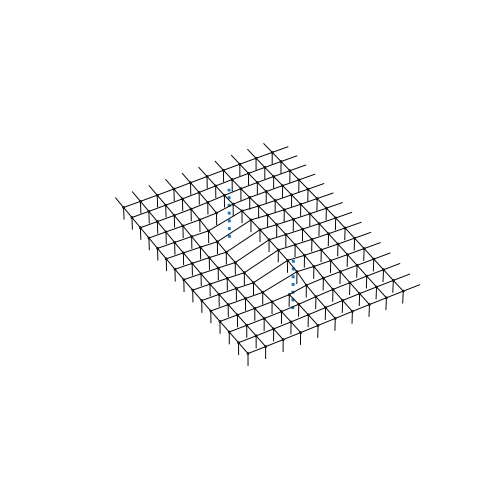

In [17]:
def kitaev_dislocation(L = 10, W = 15): #L is length chain, W is number of stacked chains in y direction

    def edge_dislocation(model, L=10, W=15):
        syst = kwant.Builder(
            kwant.TranslationalSymmetry((L, 0, 0), (0, W, 0), (0, 0, 1))
        )
    
        # Interchange x- and z- hopping
        lat = list(model.sites())[0].family
        rotated = kwant.Builder(model.symmetry)
        rotated[lat(0, 0, 0)] = model[lat(0, 0, 0)]
        rotated[kwant.HoppingKind((1, 0, 0), lat)] = model[next(kwant.HoppingKind((0, 0, 1), lat)(model))]
        rotated[kwant.HoppingKind((0, 1, 0), lat)] = model[next(kwant.HoppingKind((0, 1, 0), lat)(model))]
        rotated[kwant.HoppingKind((0, 0, 1), lat)] = model[next(kwant.HoppingKind((1, 0, 0), lat)(model))]
        syst.fill(
            rotated,
            shape=(
                lambda site: 0 <= site.pos[0] < L and 0 <= site.pos[1] < W
            ),
            start=(0, 0, 0)
        )
    
        def removed_layer(site):
            x, y, _ = site.pos
            return x == L//2 and W//4 < y < 3*W//4
    
        to_delete = [site for site in syst.sites() if removed_layer(site)]
        for site in to_delete:
            syst[
                site.family(*(site.tag - (1, 0, 0))),
                site.family(*(site.tag + (1, 0, 0)))
            ] = syst[
                site, site.family(*(site.tag + (1, 0, 0)))
            ]
        del syst[to_delete]
    
        return syst
    
    def onsite(site, mu):
        return -mu*pauli.sz
    
    def hopx(site1, site2, t, Delta):
        return -(t*pauli.sz + 1j*Delta*pauli.sy)
    
    def hopy(site1, site2, t, Delta):
        return -(t*pauli.sz + 1j*Delta*pauli.sy)
    
    def hopz(site1, site2, t, Delta):
        return -(t*pauli.sz + 1j*Delta*pauli.sy)
    
    lat = kwant.lattice.cubic(norbs=2)
    sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))
    sys[lat(0,0,0)] = onsite
    sys[kwant.HoppingKind((1, 0, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    sys[kwant.HoppingKind((0, 0, 1), lat)] = hopz

    dis_sys = edge_dislocation(sys, L, W)
    return dis_sys

L, W = 10, 15
x0, y0, y1 = L//2 - 0.5, W//4 + 0.5, 3*W//4 - 0.5


def displacement(x, y):
    x -= x0
    return -np.angle(np.sqrt((y - y0 - 1j*x) * (y - y1 + 1j*x))) / (np.pi)

fig = kwant.plot(
    kitaev_dislocation(),
    site_size=.02, hop_lw=.05, fig_size=(9, 9), show=False,
    pos_transform=(
        lambda pos: [pos[0], pos[1], pos[2] + displacement(pos[0], pos[1])]
    )
)
ax = fig.axes[0]
ax.view_init(elev=40, azim=60)
ax.plot(
    [x0, x0, np.nan, x0, x0], [y0, y0, np.nan, y1, y1], [-2, 2, np.nan, -2, 2],
    lw=3, linestyle=":"
)
ax.axis("off");

In [19]:
def plot_spec(mu):
    p =dict(mu = mu, t = 0.5, Delta = 0.1, k_x=0, k_y=0, k_z=0)

    sys = kitaev_dislocation(L = 15, W = 15)
    sys = kwant.wraparound.wraparound(sys).finalized()
    H = sys.hamiltonian_submatrix(params=p)
    vals= np.linalg.eigvalsh(H)
    plt.xlabel("Energy index")
    plt.ylabel("E")
    plt.xlim(200, 240)
    # plt.ylim(-1, 1)
    plt.title(fr"Spectrum for $\mu$ = {np.round(mu,2)}")
    plt.scatter(range(len(vals)),vals, s= 5);

mu_slider = widgets.FloatSlider(value=0.5, min=-1.2, max=1.2, step=0.05, description=r'$\mu$:')
interactive_plot=widgets.interactive(plot_spec, mu=mu_slider)
display(interactive_plot) 

interactive(children=(FloatSlider(value=0.5, description='$\\mu$:', max=1.2, min=-1.2, step=0.05), Output()), …

In [20]:
def plot_bands(mu, t, Delta):
    p =dict(mu = mu, t = t, Delta = Delta, k_x=0, k_y=0, k_z=0)
    kz = np.linspace(-np.pi/2, np.pi/2, 300)
    all_energies = []
    sys = kitaev_dislocation(L = 10, W = 15)
    sys = kwant.wraparound.wraparound(sys).finalized()
    
    for k_z in kz:
        p['k_z'] = k_z
        H = sys.hamiltonian_submatrix(params=p)
        vals = np.linalg.eigvalsh(H)
        indices = slice(len(vals)//2 - 3, len(vals)//2 + 3)
        energies = vals[indices]

        all_energies.append(energies)
    

    all_energies = np.array(all_energies)
    

    plt.figure(figsize=(8, 6))
    for band in range(all_energies.shape[1]):
        plt.plot(kz, all_energies[:, band], color='black')
    
    plt.xlabel(r'$k_z$', fontsize=14)
    plt.ylabel(r'E', fontsize=14)
    plt.title(fr'Bandstructure for $\mu$={np.round(mu,3)}, $t$={np.round(t,3)}, $\Delta$={np.round(Delta,3)}')
    plt.grid(True)
    plt.show()

t_slider = widgets.FloatSlider(value=0.4, min=0.0, max=1.0, step=0.1, description=r'$t$:')
mu_slider = widgets.FloatSlider(value=0.8, min=-1, max=1, step=0.05, description=r'$\mu$:')
D_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.1, description=r'$\Delta$:')
interactive_plot = widgets.interactive(plot_bands, mu=mu_slider, t=t_slider, Delta=D_slider)
display(interactive_plot) 

interactive(children=(FloatSlider(value=0.8, description='$\\mu$:', max=1.0, min=-1.0, step=0.05), FloatSlider…

Normal Kitaev chain should be topological for $\mu > -2t$, and cross at $\mu = |2t|$, which I do not observe. Maybe this is due to edge dislocation, but I doubt it. Plotting the spectrum just for $k_z = 0$ reveals the correct behaviour of the chain, i.e. a gap opening at the correct value of $\mu$, though only at $\mu = t$, and the presence of "zero" energy states in this region (see the plot just above this one). I do not think they are fully at zero energy, but this might be due to the finite size of the system. 

In [21]:
def plot_wf(mu, t, Delta, n = 0, kz = 0): # n is shift away (+ or -) from middle energy level
    p = dict(mu=mu, t=t, Delta=Delta, k_x=0, k_y=0, k_z=kz)
    
    # Create the dislocated Kitaev system
    sys = kitaev_dislocation(20, 25)  # Assuming this function is defined
    sys = kwant.wraparound.wraparound(sys).finalized()
    
    # Get Hamiltonian at the specified k_z
    H = sys.hamiltonian_submatrix(params=p)
    vals, vecs = np.linalg.eigh(H)
    
    # index = np.argmin(np.abs(vals))  # Get index of state with energy closest to zero
    # wave_function = vecs[:, index]   # Select the corresponding eigenstate
    n = int(len(vals)//2 + n)
    print(f"Energy = {vals[n]}")
    wave_function = vecs[:, n]

    num_sites = sys.graph.num_nodes
    prob_density = np.zeros(num_sites)

    for i in range(num_sites):
        prob_density[i] = np.abs(wave_function[2*i])**2 + np.abs(wave_function[2*i+1])**2
    
    positions = [site.pos for site in sys.sites] 
    

    plt.figure(figsize=(8, 6))
    x, y, z = zip(*positions)

    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), prob_density, (grid_x, grid_y), method='cubic')
    

    plt.imshow(grid_z.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='viridis', aspect='auto')
    plt.colorbar(label=r'$|\psi|^2$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Wave function for n ={n}, $k_z$={np.round(kz,2)}')
    plt.grid(True)
    plt.show()

t_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description=r'$t$:')
mu_slider = widgets.FloatSlider(value=1, min=-1.2, max=1.2, step=0.05, description=r'$\mu$:')
D_slider = widgets.FloatSlider(value=0.1, min=0.0, max=0.5, step=0.1, description=r'$\Delta$:')
n_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=1, description=r'$n$:')
k_slider = widgets.FloatSlider(value=0, min=-np.pi/4, max=np.pi/4, step=0.01, description=r'$k_z$:')
interactive_plot = widgets.interactive(plot_wf, mu=mu_slider, t=t_slider, Delta=D_slider, n=n_slider, kz = k_slider)
display(interactive_plot) 


interactive(children=(FloatSlider(value=1.0, description='$\\mu$:', max=1.2, min=-1.2, step=0.05), FloatSlider…

I am quite sceptical about the results. Sure, sometimes there is a strong localization of the wave function around the defect. This kind of holds on to the point where $\mu = t$, after which the same wavefunction will be strongly localized around the edge of the system; or at least away from the dislocation. No such transition is seen around $\mu = -t$, which is inline with the fact that there is not a gap opening as shown above. I will leave the conversion of edge dislocation into two disclinations for someone else.

## Week 8: General Approach to Topological Classification ✅

Looks rather difficult.. skip for now.

#### Finding gaps

Calculation of topological invariant in 1D reduces down to finding the zeros and poles of the expression $\mathrm{det}[h_0 + z t_L + z^{-1}t_R] = 0$, with $h(k)=h_0+t_Le^{ik}+t_Re^{-ik}$, and $e^{ik}=z$. 

The poles are trivial and are all located at $z=0$. A system is gapped if there is a region of energies with no propagating modes. This assignment is rather confusing and feels very basic? I do not understand the point of it.

In [22]:
def random_sys(N=4):
    onsite = randn(N, N) + 1j * randn(N, N)
    lefthopping = randn(N, N) + 1j * randn(N, N)
    righthopping = randn(N, N) + 1j * randn(N, N)
    return onsite, lefthopping, righthopping


def find_singularities(onsite, lefthopping, righthopping):
    n = len(onsite)
    A = np.block([[-righthopping, np.zeros((n, n))], [np.zeros((n, n)), np.eye(n)]])
    B = np.block([[onsite, lefthopping], [np.eye(n), np.zeros((n, n))]])
    return scipy.linalg.eigvals(A, B)

onsite, lefthopping, righthopping = random_sys()
# find_singularities(onsite, lefthopping, righthopping)

In [23]:
def ham(k, h0, tl, tr):
    return onsite + tl*np.exp(1j*k) + tr * np.exp(-1j*k)

def check_propagating_modes(onsite, lefthopping, righthopping, E, k_points=10000):
    # E a tuple of lowest and highest values of some energy range
    E_min, E_max = E
    ks = np.linspace(0, 2 * np.pi, k_points)
    for k in ks:
        H_k = ham(k, onsite, lefthopping, righthopping)
        eigenvalues = np.linalg.eigvalsh(H_k)
        if np.any((eigenvalues >= E_min) & (eigenvalues <= E_max)):
            return True 
    return False 

def has_gap(E, h0, tl, tr):
    return check_propagating_modes(h0, tl, tr, E, k_points=10000)

N = 2
E = (-1, 2)
onsite, lefthopping, righthopping = random_sys(N)
propagating = check_propagating_modes(onsite, lefthopping, righthopping, E)
print(has_gap(E, onsite, lefthopping, righthopping))

True


## Week 9: Anderson Localization and Topology ✅

#### 1D Localization

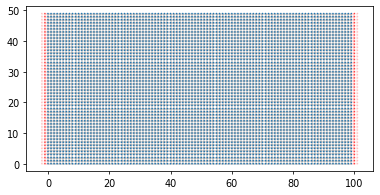

In [24]:
def onsite(site, delta):
    return np.random.uniform(-delta, delta)

def anderson(L=30, W=10, t=1):
    sys = kwant.Builder()
    lat = kwant.lattice.square(norbs = 1)
    sys[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    sys[lat.neighbors()] = - t

    lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))
    lead[(lat(0, j) for j in range(W))] = onsite
    lead[lat.neighbors()] = -t

    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    
    return sys

kwant.plot(anderson(L=100, W=50));

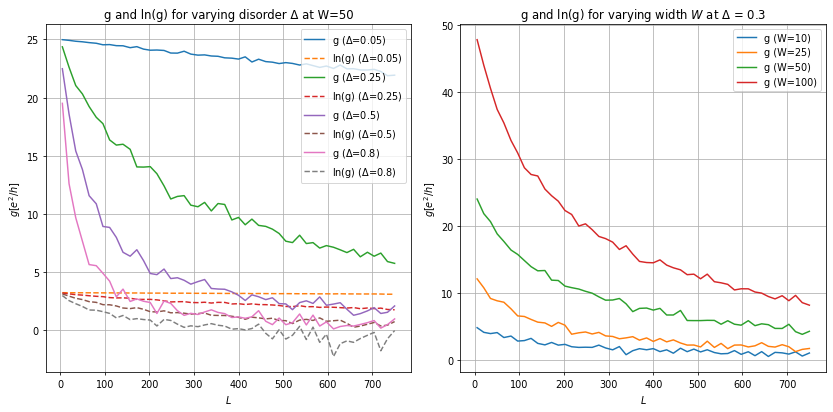

In [25]:
def compute_g(delta, L_list, W):
    p = dict(delta=delta)
    g_values = []
    for L in L_list:
        sys = anderson(L=L, W=W)
        sysf = sys.finalized()
        smatrix = kwant.smatrix(sysf, 2, params=p)
        g_values.append(smatrix.transmission(1, 0))
    return g_values

# Parameters
L_list = np.linspace(5, 750, 50).astype(int)
delta_values = [0.05, 0.25, 0.5, 0.8]
W_values = [10, 25, 50, 100]

# Creating figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting g and log(g) for different deltas
for delta in delta_values:
    g = compute_g(delta, L_list, W=50)  # Fixed W=50 for delta curves
    axs[0].plot(L_list, g, label=f'g ($\\Delta$={delta})')
    axs[0].plot(L_list, [np.log(gi) for gi in g], label=f'ln(g) ($\\Delta$={delta})', linestyle='--')

axs[0].set_title('g and ln(g) for varying disorder Δ at W=50')
axs[0].set_xlabel(r'$L$')
axs[0].set_ylabel(r'$g [e^2/h]$')
axs[0].legend()
axs[0].grid()

# Plotting for fixed delta=0.3 and varying W
delta_fixed = 0.3
for W in W_values:
    g = compute_g(delta_fixed, L_list, W)  # Fixed delta=0.3 for varying W
    axs[1].plot(L_list, g, label=f'g (W={W})')

axs[1].set_title('g and ln(g) for varying width $W$ at Δ = 0.3')
axs[1].set_xlabel(r'$L$')
axs[1].set_ylabel(r'$g [e^2/h]$')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

In the strongly localized limit $g\propto g_c e^{-L/\xi}$, so that $\xi = \frac{-L}{\ln{g/g_c}}$. The scaling seems to hold for different disorders, and different widths. However, here one needs much bigger systems when disorder is weak, which does feel a bit intuitive. In the low disorder limit $g\propto\frac{\lambda_{MFP}}{L}$, while in the strong disorder limit we have that $g\propto e^{-L/\xi}$. Then $\ln g \propto -L$, i.e. decrease linearly with L, which looks like is happening for all cases width moderately strong disorder. The case of weak disorder does also look classical for all L. 

If $\lambda_{MFP} \gg \xi$, then a system is in the metalic phase. When $\lambda_{MFP} \ll \xi$ electrons are more localized, leading to insulating behaviour. I guess that the two are related through $\lambda_{MFP}\propto e^{\xi}$.

#### Griffiths phase

In [30]:
def kitaev_chain(L=100):

    kitaev_chain_infinite = kwant.Builder(kwant.TranslationalSymmetry((-1,)))
    lat = kwant.lattice.chain(norbs=2)

    U = np.array([[1.0, 1.0], [1.0j, -1.0j]]) / np.sqrt(2)

    def onsite(onsite, mu0, t, m, D):
        mu = np.random.normal(loc=mu0, scale=D, size=1)
        return (mu+2*t+m) * pauli.sz

    def hop(site1, site2, t, delta):
        return -t * pauli.sz - 1j * delta * pauli.sy

    kitaev_chain_infinite[lat.shape(lambda pos: abs(pos[0])<20, (0,))] = onsite
    kitaev_chain_infinite[lat(0)] = onsite
    kitaev_chain_infinite[kwant.HoppingKind((1,), lat)] = hop


    finite_chain = kwant.Builder()
    finite_chain.fill(kitaev_chain_infinite, shape=(lambda site: 0 <= site.pos[0] < L), start=[0])

    return finite_chain

sys = kitaev_chain(10)
# kwant.plot(sys);

In [31]:
disorders = np.linspace(0, 1, 250)
masses = np.linspace(-1, 1 , 250)
mu0 = 0.3

def DOS(H):

    def gaussian(Ei, E, sigma=0.025): # Quite broad smearing
        return np.exp(-(E - Ei)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    E = np.linalg.eigvalsh(H)
    Emin, Emax = E[0], E[-1]
    Ebins = np.linspace(Emin, Emax, 2000)
    DOS = np.zeros(Ebins.shape)
    for Ei in E:
        DOS += gaussian(Ei, Ebins)
        
    return Ebins, DOS

def plot_DOS(m, Dis):
    sys = kitaev_chain(200)
    sysf = sys.finalized()
    params = dict(t=1.0, mu0=mu0, delta=0.4, m = m, D = Dis)
    h = sysf.hamiltonian_submatrix(params = params)
    E = np.linalg.eigvalsh(h)
    E, D = DOS(h)

    plt.title(fr'Density of states for $m$={np.round(m,3)}, Disorder strength={np.round(Dis,3)}')
    plt.xlabel(r'$E$')
    plt.ylabel(r'$\rho$')
    plt.plot(E,D)
    plt.xlim((-1,1))
    plt.grid(True)
    plt.show()



m_slider = widgets.FloatSlider(value=-mu0, min=-4*mu0, max=3*mu0, step=0.05, description='m:')
D_slider = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.01, description='D:')



interactive_plot = widgets.interactive(plot_DOS, m=m_slider, Dis=D_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=-0.3, description='m:', max=0.8999999999999999, min=-1.2, step=0.05), …

One can see that for $m > -\mu$ the system is gapped and there are no zero energy states; i.e. the wire does not host any majoranas. As $m$ switches sign, there is a state appearing at zero energy. Note that for $m$ close to -$\mu$, this may not be fully captured due to the Gaussian smearing of the energies. These majarona states are quite robust against disorder, often surviving up to a disorder of strength $t/2$. The powerlaw behaviour that is being talked about might be this $1/E^n, n \in \mathbb{N}$ behaviour that occurs between the two van Hove singularities. I do not understand the physical meaning of it. Apparently it is due to quantum Griffiths singularities, which behaves similar to Andersion localization. Then again, I have not read the article that is mentioned in the assignment.

## Week 10: Extensions of Classification I ✅

#### Weyl semimetal with time-reversal symmtery

The model for this system is based on PhysRevB.87.245112. Realizing a Weyl semimetal phase requires breaking either TRS or inversion symmetry. We break inversion symmetry here since we want to keep TRS. We do this by studying a variant of a tight-binding model on the ZnS lattice.

$$ H = \sum_{<i,j>}(t\,c^{\dagger}_ic_j + h.c.) \sum_i E_i\,c^{\dagger}_ic_i+ \sum_{<<i,j>>}( c^{\dagger}_i\mathbf{e}_{ij}\cdot\mathbf{s}c_j -h.c.).$$

The corresponding Bloch Hamiltonian is given by 

$$ H(k) = d_1(k)\sigma_x+d_2(k)\sigma_y + \epsilon\sigma_z + \sigma_z\left(D_x(k)s_x + D_y(k)s_y + D_z(k)s_z  \right),$$

where $\sigma_i$ act in sublattice space, and $s_i$ (also Pauli matrices) act in spin space. Furthermore we have

$$\begin{aligned}
d_1(k)= & t\left(1+\cos \mathbf{k} \cdot \mathbf{a}_1+\cos \mathbf{k} \cdot \mathbf{a}_2+\cos \mathbf{k} \cdot \mathbf{a}_3\right) \\
d_2(k)= & t\left(\sin \mathbf{k} \cdot \mathbf{a}_1+\sin \mathbf{k} \cdot \mathbf{a}_2+\sin \mathbf{k} \cdot \mathbf{a}_3\right) \\
D_x(k)= & \lambda\left[\sin \mathbf{k} \cdot \mathbf{a}_2-\sin \mathbf{k} \cdot \mathbf{a}_3\right. \\
& \left.-\sin \left(\mathbf{k} \cdot \mathbf{a}_2-\mathbf{k} \cdot \mathbf{a}_1\right)+\sin \left(\mathbf{k} \cdot \mathbf{a}_3-\mathbf{k} \cdot \mathbf{a}_1\right)\right]
\end{aligned}.$$

Lastly the time-reversal operator is given by $\mathcal{T} = -is_y\mathcal{K}$, and $H(k)$ should satisfy $\mathcal{T}H(k)\mathcal{T}^{-1} = H(-k)$. 

I am sure it is possible to construct this model in Kwant, but it is much more convenient to just work with the Bloch Hamiltonian, so I will do that instead. Actually, I will cheat my way through all of the mathematics and just get straight to the point of the surface states (and hence the Weyl points.)

In [26]:
# Build Hamiltonian
a = 1
a1 = a/2*np.array([0, 1, 1])
a2 = a/2*np.array([1, 0, 1])
a3 = a/2*np.array([1, 1, 0])
b1 = 2*np.pi/a*np.array([-1, 1, 1]) 
b2 = 2*np.pi/a*np.array([1, -1, 1]) 
b3 = 2*np.pi/a*np.array([1, 1, -1]) 

def d1(k, t):
    return t * (1 + np.cos(np.dot(k, a1)) + np.cos(np.dot(k, a2)) + np.cos(np.dot(k, a3)))

def d2(k, t):
    return t * (np.sin(np.dot(k, a1)) + np.sin(np.dot(k, a2)) + np.sin(np.dot(k, a3)))

def Dx(k, l):
    return l * (
        np.sin(np.dot(k, a2)) - np.sin(np.dot(k, a3))
        - np.sin(np.dot(k, a2 - a1)) + np.sin(np.dot(k, a3 - a1)))

def Dy(k, l):
    return l * (
        np.sin(np.dot(k, a3)) - np.sin(np.dot(k, a1))
        - np.sin(np.dot(k, a3 - a2)) + np.sin(np.dot(k, a1 - a2)))

def Dz(k, l):
    return l * (
        np.sin(np.dot(k, a1)) - np.sin(np.dot(k, a2))
        - np.sin(np.dot(k, a3 - a2)) + np.sin(np.dot(k, a1 - a2)))

def h(k, t, l, eps):
    # Hamiltonian is built in basis sublattice \otimes spin
    d1k = d1(k, t)
    d2k = d2(k, t)
    Dxk = Dx(k, l)
    Dyk = Dy(k, l)
    Dzk = Dz(k, l)
    
    return d1k * pauli.sxs0 + d2k * pauli.sys0 + eps*pauli.szs0 + Dxk * pauli.szsx + Dyk * pauli.szsy + Dzk * pauli.szsz

# Check time-reversal invariance

def TRS(N):
    # Naively computes the condition for N k-values.
    t = 1
    eps = 0.1
    l = 0.3
    k_points = np.random.uniform(-np.pi, np.pi, (N, 3))
    T = -1j*pauli.s0sy

    for k in k_points:
        H_k = h(k, t, l, eps)
        H_mk = h(-k, t, l, eps)
        THTinv = T @ H_k.conj() @ T.T

        if not np.allclose(THTinv, H_mk, atol=1e-8):
                return False  # Time-reversal symmetry is broken at this k-point

    return True

# print(TRS(200)) # true, of course

The dispersion of the surface states is given as $E(k_x, k_y)= \text{sign}(k_xk_y)d(q) = 4t \sin\frac{k_x a}{4}\sin\frac{k_y a}{4}$, in equation 9 of the paper.

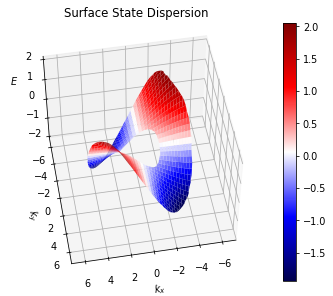

In [27]:
import matplotlib.cm as cm
m = cm.ScalarMappable(cmap=cm.seismic)
l = 0.3 
eps_ = 0.75*4*l # Fig 3b of the paper

def D(kx, ky, l):
    a = 1
    print(kx)
    q = np.array([kx, ky, 2*np.pi/a])
    return np.sqrt((Dx(q,l))**2 + (Dy(q,l))**2 + (Dz(q,l))**2)

def D(kx, ky, l):
    a = 1
    kz = 2 * np.pi / a  # kz fixed at 2pi/a
    # Calculate Dx, Dy, Dz for each (kx, ky) pair
    Dx_vals = Dx([kx, ky, kz], l)
    Dy_vals = Dy([kx, ky, kz], l)
    Dz_vals = Dz([kx, ky, kz], l)
    
    return np.sqrt(Dx_vals**2 + Dy_vals**2 + Dz_vals**2)

def E(kx, ky):
    t = 1
    a = 1
    # Check if D(kx, ky, l) is greater than eps_
    if D(kx, ky, l) > eps_:
        return 4 * t * np.sin(kx * a / 4) * np.sin(ky * a / 4)
    else:
        return np.nan  # Return NaN if D(kx, ky, l) < eps_

k = np.linspace(-2*np.pi, 2*np.pi, 200)
kx_vals, ky_vals = np.meshgrid(k, k)

energy = np.zeros_like(kx_vals)
for i in range(len(k)):
    for j in range(len(k)):
        kx = kx_vals[i, j]
        ky = ky_vals[i, j]
        energy[i, j] = E(kx, ky)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
m.set_array(energy)

f = ax.plot_surface(kx_vals, ky_vals, energy, cmap='seismic')
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$E$')
ax.set_title('Surface State Dispersion')
plt.colorbar(f)

ax.view_init(elev=50, azim=80)
plt.show()

One can see the 4 Fermi arcs in the Weyl semimetal as the 4 lines where the dispersion vanishes. These arcs connect the Weyl points, which means there is a total of 8 such Weyl points. I believe only 4 of these points are distinct, as the others are related through TRS $(k \mapsto -k)$. I also believe that the creation of these surface states breaks inversion symmetry, which is, alongside the possible breaking of TRS, a necessary condition for the formation of a Weyl semimetal

#### Graphene edge states

Graphene has two types of nanoribbons: zigzag and armchair edges. The former can host interesting edge states. Armchair edges have K and K' mapped at the same momentum.

In [32]:
def graphene_edge(W=5):
    honeycomb = kwant.lattice.honeycomb()
    a, b = honeycomb.sublattices

    def onsite(site, M, Delta):
        return np.random.uniform(-Delta, Delta)+M if site.family == a else -M

    def nn_hopping(site1, site2, t):
        return t

    def nnn_hopping(site1, site2, t_2):
        return t_2

    def ribbon_shape_zigzag(site):
        return -0.5 / np.sqrt(3) - 0.1 <= site.pos[1] < np.sqrt(3) * W / 2 + 0.01

    def ribbon_shape_armchair(site):
        return -1 <= site.pos[0] < W
    
    
    nnn_hoppings_a = (((-1, 0), a, a), ((0, 1), a, a), ((1, -1), a, a))
    nnn_hoppings_b = (((1, 0), b, b), ((0, -1), b, b), ((-1, 1), b, b))
    
    graphene = kwant.Builder(kwant.TranslationalSymmetry(*honeycomb.prim_vecs))
    graphene[honeycomb.shape(lambda pos: True, (0, 0))] = onsite
    graphene[honeycomb.neighbors()] = nn_hopping
    graphene[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings_a]] = nnn_hopping
    graphene[[kwant.builder.HoppingKind(*hopping) for hopping in nnn_hoppings_b]] = nnn_hopping

    zigzag_ribbon = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
    zigzag_ribbon.fill(graphene, ribbon_shape_zigzag, (0, 0))

    
    # Change PB for W = 7, hardcoded
    for site in zigzag_ribbon.sites():
        if site.family == a and site.pos[0] > W - 4:# Threshold to remove one 'b' site at the edge

            del zigzag_ribbon[site]
            break  # Remove only one site from sublattice 'b' and break the loop
    
    
    return zigzag_ribbon

sys = graphene_edge(7)
# kwant.plot(sys);

In [29]:
def plot_edgestate(t2, M, Delta):
    k = np.linspace(0, 2*np.pi, 300)
    Ws = [10, 7]
    p = dict(t=0.3, M=M, t_2=t2, Delta= Delta) # t = 2.7 eV for NN hopping in graphene. t2 = 0.2-0.3 eV.
# Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for i, W in enumerate(Ws):
        sys = graphene_edge(W)
        sysf = sys.finalized()

        # Plot the band structure for each width W
        ax = axs[i]
        kwant.plotter.bands(sysf, params=p, momenta=k, show=False, ax=ax)
        axs[0].set_title(f'Edge states of zigzag ribbon with AB PBC')
        axs[1].set_title(f'Edge states of zigzag ribbon with AA PBC')
        ax.set_xlabel(r'$k$')
        ax.set_ylabel(r'$E$')
        ax.xaxis.set_major_locator(plt.NullLocator())  # Hide x-axis ticks

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

t2_slider = widgets.FloatSlider(value=0., min=0., max=0.3, step=0.05, description=r'$t_2$:')
M_slider = widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.05, description=r'$M$:')
D_slider = widgets.FloatSlider(value=0.0, min=0.0, max=0.5, step=0.05, description=r'$\Delta$:')
interactive_plot = widgets.interactive(plot_edgestate, t2=t2_slider, M=M_slider, Delta=D_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.0, description='$t_2$:', max=0.3, step=0.05), FloatSlider(value=0.0,…

Breaking sublattice (chiral) symmetry by introducing a mass term gaps the system, but need not break the edge states. Introducing a NNN hopping couples the two different sublattices (breaks chiral symmetry) and moves the edge state away from zero energy. When one changes the structure of the periodic boundary conditions, one can see that the edge state breaks away from the rest of the spectrum. The edge state becomes very localized. A simple way to destroy the edge state is to change the geometry from zigzag to armchair, but this is kind of cheating. Disorder can break these edge states, as one once again breaks chiral symmetry and it can open up a gap.

Plots correspond nicely with the book "Topological Insulators and Topological Superconductors" by Andrei Bernevig.

## Week 11: Extensions of Classification II ✅

#### Floquet crystalline topological insulator

This model is inspired by https://arxiv.org/abs/2311.17018 (thank you Arnob), which uses an extended BHZ model with a mass term and has several different drives (section 2.1.2 of the paper). The Hamiltonian is given by

\begin{aligned}
\mathcal{H}_{\mathrm{BHZ}+\mathrm{WD}}(\mathbf{k})= & \lambda \sin k_x \sigma_x s_z+\lambda \sin k_y \sigma_y s_0 \\
& +\left(m_0-t \cos k_x-t \cos k_y\right) \sigma_z s_0 \\
& +\Lambda\left(\cos k_x-\cos k_y\right) \sigma_x s_x
\end{aligned}

and possesses the following symmetries

- TRS with $\mathcal{T}=i \sigma_0 s_y \mathcal{K}: \mathcal{T} \mathcal{H}(\mathbf{k}) \mathcal{T}^{-1}=\mathcal{H}(-\mathbf{k})$, if $\Lambda=0$,
- Charge conjugation symmetry with $\mathcal{C}=\sigma_x s_z \mathcal{K}$ : $\mathcal{C H}(\mathbf{k}) \mathcal{C}^{-1}=-\mathcal{H}(-\mathbf{k})$,
- Sublattice or chiral symmetry with $\mathcal{S}=\sigma_x s_y \mathcal{K}$ : $\mathcal{S H}(\mathbf{k}) \mathcal{S}^{-1}=-\mathcal{H}(\mathbf{k})$,
- Four-fold rotation symmetry with $C_4=e^{-i \frac{\pi}{4} \sigma_z s_z}$ : $C_4 \mathcal{H}\left(k_x, k_y\right) C_4^{-1}=\mathcal{H}\left(-k_y, k_x\right)$, if $\Lambda=0$,
- The combined $C_4 \mathcal{T}$ symmetry: $\left(C_4 \mathcal{T}\right) \mathcal{H}\left(k_x, k_y\right)\left(C_4 \mathcal{T}\right)^{-1}=$ $\mathcal{H}\left(k_y,-k_x\right)$.

It is a higher order topological insulator, which apparently often have surface states protected by crystalline symmetries, and hence are TCIs. In particular for the drive that I have chosen to implement, the model should host corner modes.

In [47]:
def TCI():

    def onsite(site, m0):
        return m0 * pauli.szs0

    def hopx(site1, site2, t, lambda_, Lambda):
        return t/2 * pauli.szs0 - 1j*lambda_/2 * pauli.sxsz + Lambda/2 * pauli.sxsx

    def hopy(site1, site2, t, lambda_, Lambda):
        return t/2 * pauli.szs0 - 1j*lambda_/2 * pauli.sys0 - Lambda/2 * pauli.sxsx

    lat = kwant.lattice.square(norbs=4)
    sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))

    sys[lat(0, 0)] = onsite
    sys[kwant.HoppingKind((1, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1), lat)] = hopy
    
    return sys

# kwant.plot(TCI());

def plot_bands(t, m0, lambda_, Lambda):
    p = dict(t=t, m0=m0, lambda_= lambda_, Lambda = Lambda);
    k = np.linspace(-np.pi, np.pi, 100)
    wrapped = kwant.wraparound.wraparound(TCI()).finalized();
    kwant.wraparound.plot_2d_bands(wrapped, k_x=k, k_y=k, params = p, show = False);
    plt.title(fr"TCI model for $t$={np.round(t,3)}, $m_0$={np.round(m0,3)}, $\lambda$={np.round(lambda_,3)}, $\Lambda$={np.round(Lambda,3)} ")
    plt.xlabel(r"$k_x$")
    plt.ylabel(r"$k_y$")
    plt.show()
    return 
    
    
t_slider = widgets.FloatSlider(value=1.0, min=0.0, max=1.0, step=0.1, description=r'$t$:')
m0_slider = widgets.FloatSlider(value=0.2, min=-1, max=1, step=0.1, description=r'$m_0$:')
l_slider = widgets.FloatSlider(value=0.3, min=0.0, max=1.0, step=0.1, description=r'$\lambda$:')
L_slider = widgets.FloatSlider(value=0.4, min=0.0, max=1.0, step=0.1, description=r'$\Lambda$:')
interactive_plot = widgets.interactive(plot_bands, t=t_slider, m0=m0_slider, lambda_=l_slider, Lambda=L_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='$t$:', max=1.0), FloatSlider(value=0.2, description=…

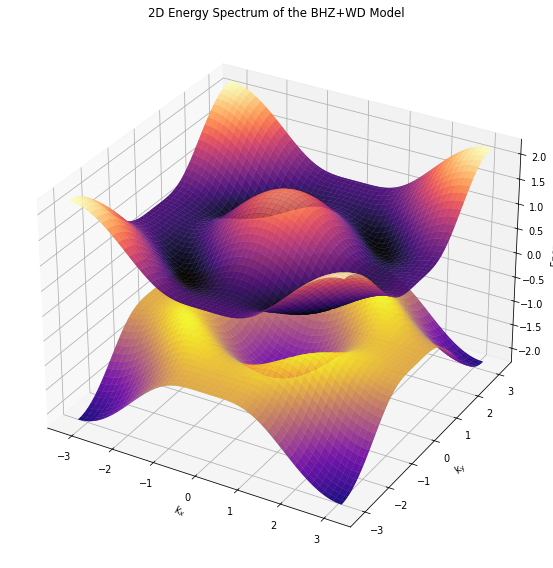

In [48]:
# Compare tight-binding model with Bloch Hamiltonian from paper

from mpl_toolkits.mplot3d import Axes3D

def H_BHZ_WD(kx, ky, t, m0, lambda_, Lambda):
    H = (lambda_ * np.sin(kx)) * pauli.sxsz + (lambda_ * np.sin(ky)) * pauli.sys0
    H += (m0 - t * np.cos(kx) - t * np.cos(ky)) * pauli.szs0
    H += Lambda * (np.cos(kx) - np.cos(ky)) * pauli.sxsx
    return H

# Define the function to plot the 2D energy spectrum (surface plot)
def plot_2D_spectrum(t, m0, lambda_, Lambda):
    kx_vals = np.linspace(-np.pi, np.pi, 100)
    ky_vals = np.linspace(-np.pi, np.pi, 100)
    KX, KY = np.meshgrid(kx_vals, ky_vals)
    

    E1 = np.zeros(KX.shape)
    E2 = np.zeros(KX.shape)
    E3 = np.zeros(KX.shape)
    E4 = np.zeros(KX.shape)

    for i in range(len(kx_vals)):
        for j in range(len(ky_vals)):
            kx = kx_vals[i]
            ky = ky_vals[j]
            H = H_BHZ_WD(kx, ky, t, m0, lambda_, Lambda)
            eigvals = np.linalg.eigvalsh(H)
            E1[j, i] = eigvals[0]
            E2[j, i] = eigvals[1]
            E3[j, i] = eigvals[2]
            E4[j, i] = eigvals[3]
    

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(KX, KY, E1, cmap='viridis', edgecolor='none', alpha=0.8, label='Band 1')
    ax.plot_surface(KX, KY, E2, cmap='plasma', edgecolor='none', alpha=0.8, label='Band 2')
    ax.plot_surface(KX, KY, E3, cmap='inferno', edgecolor='none', alpha=0.8, label='Band 3')
    ax.plot_surface(KX, KY, E4, cmap='magma', edgecolor='none', alpha=0.8, label='Band 4')
    
    ax.set_xlabel(r'$k_x$')
    ax.set_ylabel(r'$k_y$')
    ax.set_zlabel('Energy')
    ax.set_title('2D Energy Spectrum of the BHZ+WD Model')

    plt.show()

plot_2D_spectrum(t=1.0, m0=0.2, lambda_=0.3, Lambda=0.4)

In [40]:
# Step drive, as outlined in section 4.2 of the paper
from scipy import linalg as la
from functools import reduce


J1= np.pi/2 # Between 0 and Pi, pi/2 from paper
J2= 3*np.pi/8 # Between 0 and Pi/2, 3pi/8 from paper
p1 = dict(t=0, m0=1, lambda_= 0, Lambda = 0, J=J1);
p2 = dict(t=1, m0=0, lambda_= 1, Lambda = 1.0, J=J2);

def evolution_operator(hamiltonians, T):
    n = len(hamiltonians)
    exps = [la.expm(-1j * h * T / n) for h in hamiltonians]
    return reduce(np.dot, exps)

def dispersion(T):
    syst = TCI()
    B = np.array(syst.symmetry.periods).T
    A = B @ np.linalg.inv(B.T @ B)
    syst = kwant.wraparound.wraparound(syst).finalized()

    def hamiltonian_k(p):
        def f(k_x, k_y):
            k_x, k_y = np.linalg.lstsq(A, [k_x, k_y], rcond=None)[0]
            ham = p["J"]*syst.hamiltonian_submatrix(params=dict(**p, k_x=k_x, k_y=k_y))
            return ham

        return f

    hamiltonians_k = [
        hamiltonian_k(p1),
        hamiltonian_k(p2)]

    def get_energies(k_x, k_y):
            hamiltonians = [h_k(k_x, k_y) for h_k in hamiltonians_k]
            U = evolution_operator(hamiltonians, T)
            ev = np.sort(np.angle(la.eigvals(U)))
            return ev
    
    K = np.linspace(-np.pi, np.pi, 50)
    energies = np.array([[get_energies(k_x, k_y) for k_x in K] for k_y in K])

    return energies


def plot_dispersion(T):
    k = np.linspace(-np.pi, np.pi, 50)
    E = dispersion(T*np.pi)

    KX, KY = np.meshgrid(k, k)

    E1 = E[:, :, 0]
    E2 = E[:, :, 1]
    E3 = E[:, :, 2]
    E4 = E[:, :, 3]

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot for the four energy bands
    ax.plot_surface(KX, KY, E1, cmap='viridis', edgecolor='none', alpha=0.8, label='Band 1')
    ax.plot_surface(KX, KY, E2, cmap='plasma', edgecolor='none', alpha=0.8, label='Band 2')
    ax.plot_surface(KX, KY, E3, cmap='inferno', edgecolor='none', alpha=0.8, label='Band 3')
    ax.plot_surface(KX, KY, E4, cmap='magma', edgecolor='none', alpha=0.8, label='Band 4')
    
    ax.set_xlabel(r'$k_x$')
    ax.set_ylabel(r'$k_y$')
    ax.set_zlabel('Energy')
    ax.set_title(fr'Bulk spectrum of the FTCI for $T$ = {np.round(T,2)}$\pi$')

    plt.show()

    return


T_slider = widgets.FloatSlider(value=1, min=0.0, max=4, step=0.01, description=r'$T/\pi$:')
interactive_plot = widgets.interactive(plot_dispersion, T=T_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, description='$T/\\pi$:', max=4.0, step=0.01), Output()), _dom_cla…

To verify the correctness of the implementation, I will reproduce the phase space and the quasienergies. I will not visualize the corner modes but will just assume they are there and leave the LDOS to someone else.

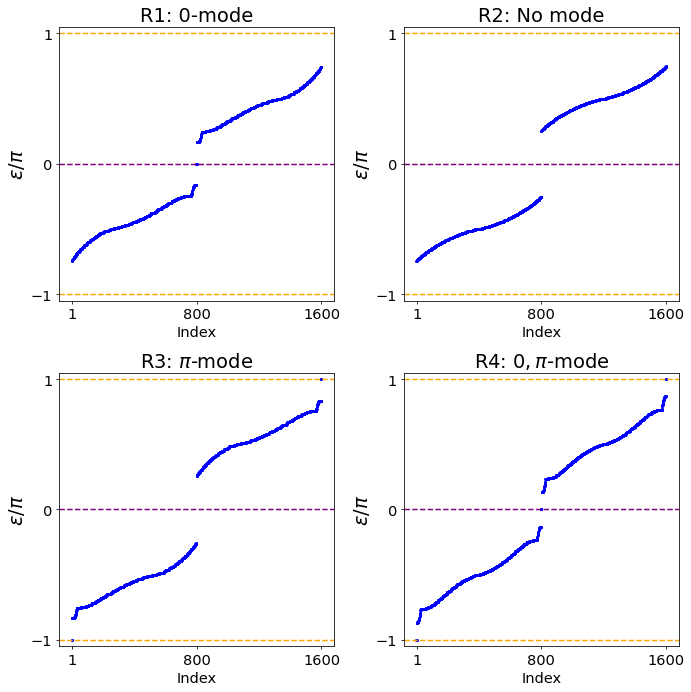

In [49]:
def TCI_finite(Lx = 20, Ly = 20):

    def onsite(site, m0):
        return m0 * pauli.szs0

    def hopx(site1, site2, t, lambda_, Lambda):
        return t/2 * pauli.szs0 - 1j*lambda_/2 * pauli.sxsz + Lambda/2 * pauli.sxsx

    def hopy(site1, site2, t, lambda_, Lambda):
        return t/2 * pauli.szs0 - 1j*lambda_/2 * pauli.sys0 - Lambda/2 * pauli.sxsx

    lat = kwant.lattice.square(norbs=4)
    sys = kwant.Builder(kwant.TranslationalSymmetry(*lat.prim_vecs))

    sys[lat(0, 0)] = onsite
    sys[kwant.HoppingKind((1, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1), lat)] = hopy

    finite_sys = kwant.Builder()
    finite_sys.fill(sys, shape=(lambda site: 1<=site.pos[0]<=Lx and 1<=site.pos[1]<=Ly), start=(1, 1))
    
    return finite_sys


def evolution_operator(hamiltonians):  # Something might be off in the function provided by the course; it only gives one of the four different phases. I explicitly construct it here for my system. 
    u1 = la.expm(-1j*p1["J"]*hamiltonians[0]*(T/2.0))
    u2 = la.expm(-1j*p2["J"]*hamiltonians[1]*(T/2.0))
    return u2@u1
    

def floquet_U(p1, p2):
    finite_sys = TCI_finite(20, 20).finalized()
    H1 = finite_sys.hamiltonian_submatrix(params=p1)
    H2 = finite_sys.hamiltonian_submatrix(params=p2)
    hamiltonians = [H1, H2]
    
    U_T = evolution_operator(hamiltonians)
    
    return U_T


def spectrum(p1, p2):
    U = floquet_U(p1, p2)
    vals = la.eigvals(U)
    ev = np.sort(np.angle(vals))/np.pi
    return ev

T=2.0

# R1
J1= 1.0*np.pi/4.0
J2= 1.0*np.pi/(2.0*2.0)

p1 = dict(t=0, m0=1, lambda_= 0, Lambda = 0, J=J1); #H1_2D
p2 = dict(t=+1, m0=0, lambda_= 1, Lambda = 1, J=J2); #H2_2D
e1 = spectrum(p1,p2)

# R2
J1= 1.0*np.pi/2.0
J2= 1.0*np.pi/(4.0*2.0)
p1 = dict(t=0, m0=1, lambda_= 0, Lambda = 0, J=J1); #H1_2D
p2 = dict(t=+1, m0=0, lambda_= 1, Lambda = 1, J=J2); #H2_2D
e2 = spectrum(p1,p2)


# R3
J1= 3.0*np.pi/4.0
J2= 1.0*np.pi/(2.0*2.0)
p1 = dict(t=0, m0=1, lambda_= 0, Lambda = 0, J=J1); #H1_2D
p2 = dict(t=+1, m0=0, lambda_= 1, Lambda = 1, J=J2); #H2_2D
e3 = spectrum(p1,p2)


# R4
J1= 1.0*np.pi/2.0
J2= 3.0*np.pi/(4.0*2.0)
p1 = dict(t=0, m0=1, lambda_= 0, Lambda = 0, J=J1); #H1_2D
p2 = dict(t=+1, m0=0, lambda_= 1, Lambda = 1, J=J2); #H2_2D
e4 = spectrum(p1,p2)

es = [e1, e2, e3, e4]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, e in enumerate(es):
    axs[i].set_xlabel('Index', fontsize=15)
    axs[i].set_ylabel(r'$\epsilon/\pi$',fontsize=20)
    axs[i].set_xticks([1, 800, 1600])
    axs[i].set_yticks([-1, 0, 1])
    axs[i].set_ylim(-1.05, 1.05)
    axs[i].tick_params(axis='both', which='major', labelsize=15)

    axs[i].axhline(0, color='purple', linestyle='--', linewidth=1.5)
    axs[i].axhline(1, color='orange', linestyle='--', linewidth=1.5)
    axs[i].axhline(-1, color='orange', linestyle='--', linewidth=1.5)
    axs[i].scatter(range(len(e)), e, s= 4, color='blue')

    axs[0].set_title(f'R{1}: 0-mode', fontsize=20)
    axs[1].set_title(f'R{2}: No mode', fontsize=20)
    axs[2].set_title(rf'R{3}: $\pi$-mode', fontsize=20)
    axs[3].set_title(rf'R{4}: $0, \pi$-mode', fontsize=20)



plt.tight_layout()
plt.show()


As one can see, we observe all four different phases at the right parameter values in the system. As a bonus, this Floquet topological crystalline insulator is also gapped in the R2 phase.

## Week 12: Beyond Single-Particle Physics ✅

No programming assignments this week.